# Homework 3 
Author - Jackson Paull
Date - 19 October 2023

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
def load_image(path: str, 
               dtype='float', 
               convert_grayscale=True, 
               transform=None, 
               **transform_kwargs):
    img = np.array(cv2.imread(path))
    if dtype=='float':
        img = img / 255
    if convert_grayscale:
        img = img.mean(axis=-1).astype(dtype)
    if transform is not None:
        img = transform(img, **transform_kwargs)
    return img

# Question 1: Band-Pass Filtering

The goal of this problem is to implement a band-pass filter using two Gaussian filters. The DoG
filter (The Difference of Gaussian) is defined as the difference of two Gaussian kernels with
different variances 𝜎1 and 𝜎2. For simplicity, let 𝜎2 = 𝑘 𝜎1 for some k and subtract the Gaussian
kernel with variance 𝜎1 from the kernel with 𝜎2. (Helpful functions: getGaussianKernel,
plot_surface, copyMakeBorder, filter2D)



## a)
You need to write a 2d-DoG function, “myDoG(DoGsize, sigma1, k)”. This function produces a kernel of size DoGsize that is the difference of two gaussian kernels
with corresponding variances 𝜎1 and 𝜎2 = 𝑘 𝜎1.

In [3]:
def myDoG(DoGsize, sigma1, k, denorm=True):
    sigma2 = k * sigma1
    norm = lambda sig: np.sqrt(2 * np.pi * (sig **2)) if denorm else lambda sig: 1

    k1 = cv2.getGaussianKernel(DoGsize, sigma1) * norm(sigma1)
    k1 = np.dot(k1, k1.T)
    k2 = cv2.getGaussianKernel(DoGsize, sigma2) * norm(sigma2)
    k2 = np.dot(k2, k2.T)

    return k2 - k1

## b)
Use this function to generate four 2d-DoG filters with 𝜎1 = 1, 2, 3, 4, k = 1.5, and a window size ten times 𝜎1. Show the 3d illustration of the four 2d-DoG filters in a
2x2 grid with appropriate labels.

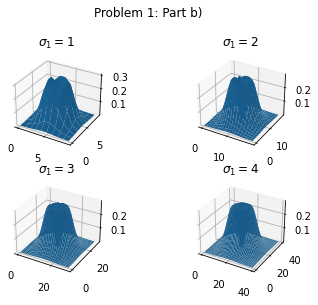

In [4]:
# Generate filters
filters = []
for s in np.arange(1, 5):
    DoGsize = 10 * s
    filters.append(myDoG(DoGsize, s, 1.5))


fig, axs = plt.subplots(2, 2, subplot_kw={'projection':'3d'})
fig.suptitle('Problem 1: Part b)')

for i, f in enumerate(filters):
    ax = axs[i // 2, i % 2]

    Z = filters[i]

    X = np.arange(Z.shape[0])
    Y = np.column_stack([X] * Z.shape[1])
    X = np.row_stack([X] * Z.shape[0])
    ax.plot_surface(X, Y, Z)
    ax.set_title(f'$\sigma_1 = {i + 1}$')

fig.tight_layout()

## c) 
Read in cars.jpg and convert it to gray-scale. Generate the same four 2d-DoG filters as in part b. Apply the filters to cars.jpg using a method of your choosing (recall the
methods used in HW2). Display the filtered images in a 2x2 grid with the appropriate
labels. Write a few lines on what you observe, and why.

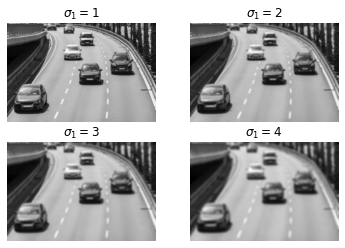

In [5]:
cars = load_image('./Images/cars.jpg')
fix, axs = plt.subplots(2, 2)
fig.suptitle('Problem 1: Part c)')

for i, f in enumerate(filters):
    ax = axs[i // 2, i % 2]
    ax.axis('off')
    ax.set_title(f'$\sigma_1 = {i+1}$')

    img = cv2.filter2D(cars, -1, f)
    ax.imshow(img, cmap='gray')

plt.show()

Here we can see that as $\sigma_1$ increases we get a greater "blurring" effect. This is due to the kernel values being more uniformly distributed over a wider range, so a given pixel will have its value modified more significantly by its neighbors.

Interestingly, in all cases, this specific band pass filter will yield an image for which $J(i, j)$ does not depend at all on $I(i, j)$, since the kernel has a value of 0 at its center

# Question 2: Non Local (NL) Means

Here we will be looking at the application of Non-Local Means in removing noise. Helpful
functions: skimage.util.view_as_windows, scipy.spatial.distance.cdist, padarray, im2col, pdist2,
sum, reshape.

## a) 

You need to read bird.jpg, convert it to grayscale, and resize the image so that
it is a perfect square. Display this resulting image.

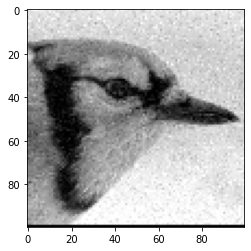

In [6]:
bird = load_image('./Images/bird.jpg', transform= lambda x: np.pad(x, ((0, 1), (0,0))))
plt.imshow(bird, cmap='gray')
plt.show()

## b) 

You will now calculate the Luminance Similarity Measure “W(m,i)” between all
the 3x3 square windows in the image, using the information given in Module 5 slide 14
onwards. Use Kw = 1 and 𝜎w = 1. Normalize “W(m, i)” so that the sum across each row is
equal to 1.0. Note that even though this is a small image, this step will likely take a while
to execute (a few minutes depending on hardware)

In [7]:
def lum_sim_measure(img, Kw=1, sigw=1, window_size=3):
    all_pixels = np.array(list(itertools.product(np.arange(img.shape[0]), np.arange(img.shape[1]))))
    W = np.zeros(tuple(itertools.chain(img.shape, img.shape)))

    img = cv2.copyMakeBorder(img, 
                                window_size//2,
                                window_size//2,
                                window_size//2,
                                window_size//2,
                                borderType=cv2.BORDER_DEFAULT)
    for m, n in tqdm(all_pixels):
        for i, j in all_pixels:
            if W[m, n, i, j] != 0:
                # Matrix has a hyperplane of symettry, so we can skip computation
                W[i, j, m, n] = W[m, n, i, j]
                continue
            wi = img[i:i+window_size, j:j+window_size]
            wm = img[m:m+window_size, n:n+window_size]
            w = np.sum(np.square(wi - wm))
            W[i, j, m, n] = Kw * np.exp(-w/(sigw**2))

    return W

In [8]:
W_unnorm = lum_sim_measure(bird)

# Create normalization matrix
norm = np.broadcast_to(W_unnorm.sum(axis=(2,3)), W_unnorm.shape).T
norm = np.swapaxes(norm, 0, 1)

W = W_unnorm / norm # Normalize

100%|██████████| 10000/10000 [11:44<00:00, 14.19it/s]


## c)

From all the windows, we will now compare the similarity measure images
generated between choosing two different windows in the image. For this part, take the
3x3 window in the top-left corner of the image, and reshape it to a 3x3 matrix. Take the
first row in W which corresponds to all of the pair-wise distances to that 3x3 window, and
reshape it to the size of the image. Display the resulting window and image side by side
with appropriate labels.

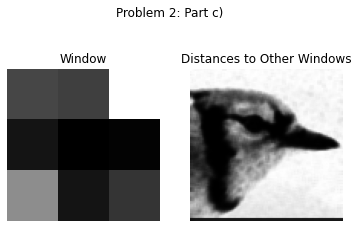

In [9]:
window = bird[0:3, 0:3]
distances = W[0,0,:,:]

fig = plt.figure()
fig.suptitle('Problem 2: Part c)')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(window, cmap='gray')
ax1.axis(False)
ax1.set_title('Window')

ax2.imshow(distances, cmap='gray')
ax2.axis(False)
ax2.set_title('Distances to Other Windows')
plt.show()

## d) 

You will now need to repeat the same operation you did in part c), but by
taking the 3x3 window in the middle of the left side of the image. Display the resulting
window and the original image side by side with appropriate labels.

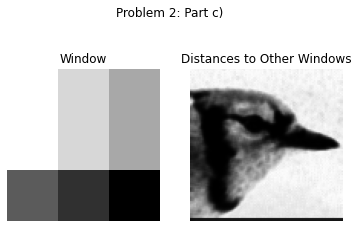

In [10]:
h = bird.shape[1] // 2 # Middle of image

window = img[0:3, h: h + 3]
distances = W[0,h,:,:]

fig = plt.figure()
fig.suptitle('Problem 2: Part c)')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(window, cmap='gray')
ax1.axis(False)
ax1.set_title('Window')

ax2.imshow(distances, cmap='gray')
ax2.axis(False)
ax2.set_title('Distances to Other Windows')
plt.show()

## e)
Using the luminance similarity measure, perform Non Local (NL) Means
filtering on bird.jpg, and remove the noise. Display the resulting image and the original
image in a 2x1 grid with appropriate results. Comment a few lines on the result achieved.


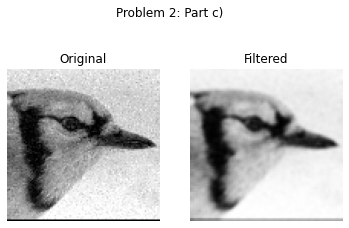

In [11]:
def NL_filter(img, weights):
    return (img * weights).sum(axis=(2,3))


filtered = NL_filter(bird, W)

fig = plt.figure()
fig.suptitle('Problem 2: Part c)')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(bird, cmap='gray')
ax1.axis(False)
ax1.set_title('Original')

ax2.imshow(filtered, cmap='gray')
ax2.axis(False)
ax2.set_title('Filtered')
plt.show()

# Question 3: Block Truncation Coding (BTC)

BTC is a fast and lossy compression technique. In this problem, we will understand how BTC is
used, along with its advantages and disadvantages. 4x4 blocks are used where applicable in
the following sub-problems. You can use the following link to learn more about BTC:
https://en.wikipedia.org/wiki/Block_Truncation_Coding#Encoder . Helpful functions: col2im,
im2col, bi2de, de2bi

## a)

You should read bevo.jpg, and make it grayscale. Resize the image by a factor
of ½ to make the compression faster. Resize the image further such that the height and
width of the images are both multiples of 4; such that it is still roughly the same
dimensions as ½ of the original image dimensions. Display the grayscale compressed
image.


In [12]:
def scale_img(img, f):
    dx = int(img.shape[1] * f)
    dy = int(img.shape[0] * f)
    return cv2.resize(img, dsize=(dx, dy))

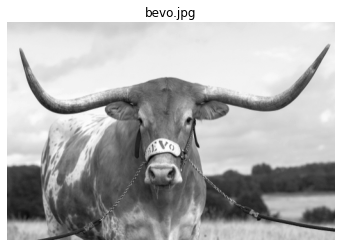

In [13]:
bevo = load_image('./Images/bevo.jpg', dtype='uint8', transform=scale_img, f=0.5)
roundTo4 = lambda x: x - x % 4
new_size = (roundTo4(bevo.shape[1]), roundTo4(bevo.shape[0]))
bevo = cv2.resize(bevo, dsize=new_size)

plt.imshow(bevo, cmap = 'gray')
plt.axis('off')
plt.title('bevo.jpg')
plt.show()

## b)

Write a function to compute the mean and standard deviation of a 4x4 block
with ‘B1’ bits to compute and store the mean, and ‘B2’ bits to compute and store the
standard deviation; where ‘B1’ and ‘B2’ are input parameters to the function. Hint: you
might need to compute the mean and standard deviation values, and then truncate in the
end based on ‘B1’ and ‘B2’ parameter values.

In [14]:
def compute_MSD(block: np.ndarray, b1: int, b2: int):
    # Calculate mean and std
    if block.dtype == float:
        block = (block * 255).astype('uint8')
    else:
        try:
            block = block.astype('uint8')
        except:
            raise ValueError('Image Passed in cannot be converted to int')


    mean, std = block.mean(axis=(-2,-1)), block.std(axis=(-2,-1))
    mean, std = mean.astype('int'), std.astype('int')
    quant = lambda x, b: x // (2 ** (8-b)) * (2 ** (8-b))
    q_mean = quant(mean, b1)
    q_std = quant(std, b2)

    # My previous implementation
    # mean = np.clip(0, 2**b1)
    # std = np.clip(0, 2**b2)

    return q_mean, q_std

## c)

Write a function to compute the 4x4 BTC binary block by thresholding the input
4x4 image block at the mean. Pass bevo.jpg through this function for 3 different ‘B1’, ‘B2’
settings; {2,1}, {3,3}, and {7,5}. Compute the BTC binary blocks image for bevo.jpg, and
display the 3 images in a 3x1 grid with appropriate labels.

In [15]:

def undo_window(windows):
    rows = []
    for r in range(windows.shape[0]):
        rows.append(np.column_stack([windows[r,i] for i in range(windows.shape[1])]))

    return np.row_stack(rows)


def encode_BTC(img, b1, b2, window_size=4):

    # View as windows
    windows = np.lib.stride_tricks.sliding_window_view(img, (window_size,window_size))[::window_size, ::window_size]
    q_mean, q_std = compute_MSD(windows, b1, b2)

    # Threshold each window    
    m = np.expand_dims(q_mean, axis=(2,3)) # Compare to true
    thresh = np.where(windows > m, 1, 0)

    # Combine back together
    encoded = undo_window(thresh)
    return encoded, q_mean, q_std

In [16]:
data = [
    ('{2,1}', 2, 1),
    ('{3,3}', 3, 3),
    ('{7,5}', 7, 5)
]

encoded = []

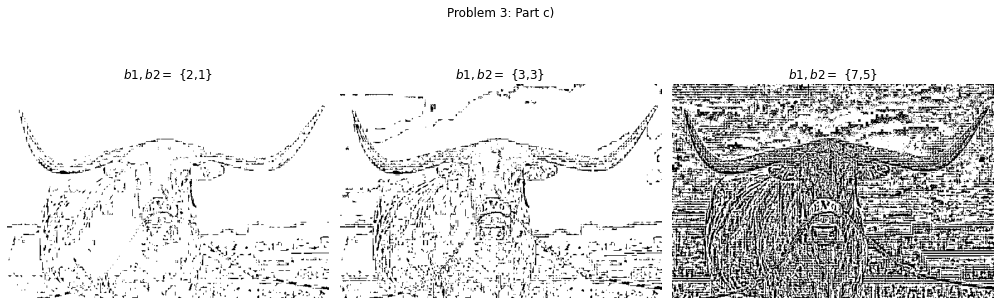

In [17]:
fig, axs = plt.subplots(1, 3)
fig.suptitle('Problem 3: Part c)')
fig.set_size_inches(14, 5)

for i, d in enumerate(data):
    name, b1, b2 = d
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f'$b1, b2 =$ {name}')

    enc = encode_BTC(bevo, b1, b2)
    img, q_mean, q_std = enc
    encoded.append((d, enc)) # Cache for loater
    ax.imshow(img, cmap='gray')


fig.tight_layout()
plt.show()

## d)

Write a function to decode a 4x4 BTC binary block given the mean and
standard deviation as the input parameters, and get back the original 4x4 image block.
Pass the 3 BTC binary block images generated in part c) through this function, for the
aforementioned ‘B1’, ‘B2’ settings; and get back the 3 decompressed bevo.jpg images.
Display these three images along with the original image in a 2x2 grid with appropriate
labels.

In [18]:
def decode_BTC(img, mean, std, window_size=4):
    windows = np.lib.stride_tricks.sliding_window_view(img, (window_size,window_size))[::window_size, ::window_size]

    Q = np.sum(windows, axis=(-2, -1))
    P = window_size ** 2 - Q
    A = np.sqrt(Q/P)

    # This might generate some runtime warnings, but we are okay with how numpy handles it
    pos = np.expand_dims(mean + std/A, (2,3))
    neg = np.expand_dims(mean - std*A, (2,3))

    return undo_window(np.where(windows == 1, pos, neg))


C:\Users\Jackson\AppData\Local\Temp/ipykernel_15800/3587920854.py:6: RuntimeWarning: divide by zero encountered in divide
  A = np.sqrt(Q/P)
C:\Users\Jackson\AppData\Local\Temp/ipykernel_15800/3587920854.py:10: RuntimeWarning: invalid value encountered in multiply
  neg = np.expand_dims(mean - std*A, (2,3))
C:\Users\Jackson\AppData\Local\Temp/ipykernel_15800/3587920854.py:9: RuntimeWarning: invalid value encountered in divide
  pos = np.expand_dims(mean + std/A, (2,3))


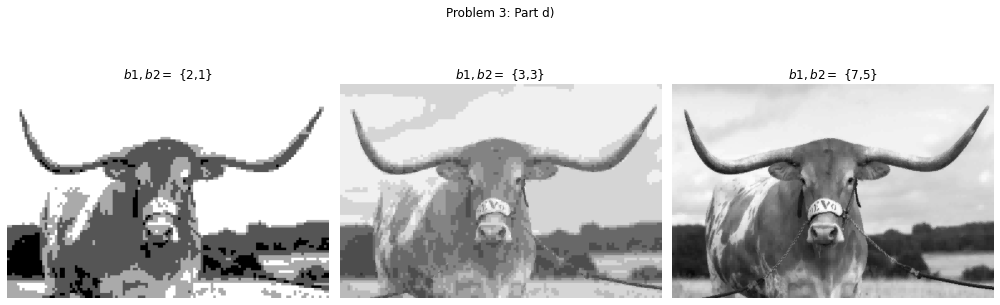

In [19]:
fig, axs = plt.subplots(1, 3)
fig.suptitle('Problem 3: Part d)')
fig.set_size_inches(14, 5)

for i, x in enumerate(encoded):
    n, d = x
    name, b1, b2 = n
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f'$b1, b2 =$ {name}')

    enc, m, s = d
    decoded = decode_BTC(enc, m, s)
    ax.imshow(decoded, cmap='gray')

fig.tight_layout()
plt.show()

## e)

Compute and report the compression ratios for the 3 BTC encoded images
generated

In [20]:

binary_img_bits = bevo.shape[0] * bevo.shape[1]
n_blocks = binary_img_bits // 16
orig_bits = binary_img_bits * 8

print(' ' * 5, 'COMPRESSION RATIOS: (b1, b2) -> CR')
print('=' * 50)
for name, b1, b2 in data:
    encoded_bits = binary_img_bits + n_blocks * (b1 + b2)
    compression_ratio = orig_bits / encoded_bits
    print(f'  {name} -> {compression_ratio:.2f}:1')

      COMPRESSION RATIOS: (b1, b2) -> CR
  {2,1} -> 6.74:1
  {3,3} -> 5.82:1
  {7,5} -> 4.57:1


# Question 4: VGG19 Feature Extractoin

VGG19 is a convolutional neural network architecture used primarily for image classification.
The network is primarily composed of 3x3 convolutional filters, making it effective at capturing
intricate and abstract features in images. In this problem we will utilize a pre-trained VGG19
network to extract features maps from an image. These features can be very useful for other
applications; for example, you can compare two images by comparing their corresponding
extracted feature maps instead of using their original representations which can help highlight
perceptually relevant differences. For more on this see https://arxiv.org/pdf/1603.08155.pdf


In [22]:
import torch
from torchvision.models import vgg19

## a)

Download and load a pre-trained version of the VGG19 model. Most machine
learning frameworks should have a way to download and use pre-trained networks
directly. With PyTorch you can use their pretrained model.

In [23]:
vgg = vgg19()

## b)

Read lion.jpg and transform it so that it is suitable for the model. The
corresponding transform may depend on the pre-trained version of the model that you
are using. For the default version in PyTorch, you will need to resize the image to
224x224 and normalize it to the ImageNet dataset mean = [0.485, 0.456, 0.406] and std
= [0.229, 0.224, 0.225]. Display the transformed image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


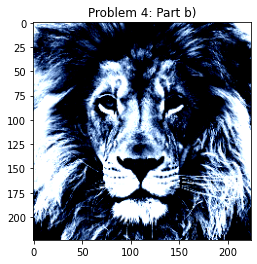

In [24]:
lion = load_image('./Images/lion.jpg', convert_grayscale=False)

# Following pytorch documentation preprocessing
# The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, 
lion = cv2.resize(lion, (256, 256), interpolation=cv2.INTER_LINEAR)

# followed by a central crop of crop_size=[224]. 
lion = lion[16:-16, 16:-16]


# Finally the values are first rescaled to [0.0, 1.0]
lion = lion - lion.min()
lion = lion / lion.max()

# Then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
lion = lion - [0.485, 0.456, 0.406]
lion = lion / [0.229, 0.224, 0.225]

plt.imshow(lion)
plt.title('Problem 4: Part b)')
plt.show()

## c) 

Experiment with passing the transformed image through layers of the network.
Note that you may need to add a dummy batch dimension to the input tensor for the
model to accept it. Find three feature maps that look interesting to you and display them.
In Pytorch you can get a list of vgg19’s layers by accessing its features field. Then you
can use slicing to use only a subset of these layers and get the results of passing your
input through them.


In [25]:
# Further manipulate image to match vgg19 input specficiations
img = np.swapaxes(lion, 0, 2)
img = np.swapaxes(img, 1, 2)
img = np.expand_dims(img, 0)
x = torch.Tensor(img)

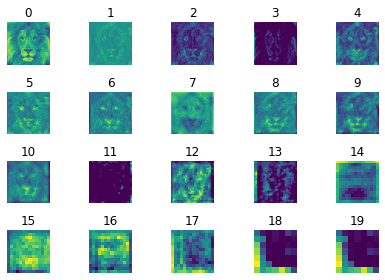

In [26]:
# Exploration of different feature maps
fig, axs = plt.subplots(4, 5)

for i in range(20):
    ax = axs[i // 5, i % 5]
    ax.axis('off')
    ax.set_title(i)
    f = vgg.features[:i*2+1](x)
    feat = f[0].detach().numpy()
    ax.imshow(feat[0])

fig.tight_layout()
plt.show()

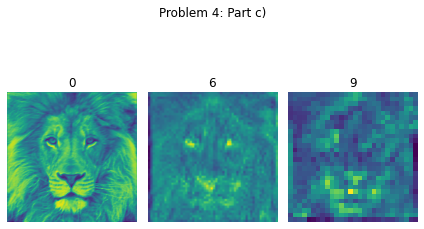

In [27]:
# I personally think 0, 6, and 9 look cool
fig, axs = plt.subplots(1, 3)
fig.suptitle('Problem 4: Part c)')

for i, n in enumerate([0, 6, 9]):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(n)
    f = vgg.features[:n*2+1](x)
    feat = f[0].detach().numpy()
    ax.imshow(feat[0])

fig.tight_layout()
plt.show()